## Evaluation Pipelin for the Model
## Init & Load

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np

from matplotlib import patches,  lines
from matplotlib.patches import Polygon

from models import build_model

In [3]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))
    plt.imshow(np_image)
    plt.axis('off')
    # plt.show()
    plt.savefig('temp_cache.png',bbox_inches='tight')
    return 'temp_cache.png'


def add_res(results, ax, color='green'):
    #for tt in results.values():
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']
        #keep = scores >= 0.0
        #bboxes = bboxes[keep].tolist()
        #labels = labels[keep].tolist()
        #scores = scores[keep].tolist()
    #print(torchvision.ops.box_iou(tt['boxes'].cpu().detach(), torch.as_tensor([[xmin, ymin, xmax, ymax]])))
    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

In [4]:
ckpt = torch.load('/scratch/chaijy_root/chaijy2/jiayipan/ACL/RefCloze/outputs/15w.pth')
model, criterion, contrastive_criterion, qa_criterion, mvm_criterion, mlm_criterion, weight_dict = build_model(ckpt['args'])
model.load_state_dict(ckpt['model'])
model.eval()
model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MDETR(
  (transformer): Transformer(
    (vl_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, o

## Eval

In [5]:
def plot_inference(im, caption, lang_only=False):
  with torch.no_grad():
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).cuda()

    # propagate through the model
    memory_cache = model(img, [caption], encode_and_save=True, lang_only=lang_only)
    outputs = model(img, [caption], encode_and_save=False, memory_cache=memory_cache, lang_only=lang_only)

    # keep only predictions with 0.7+ confidence
    probs = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
    keep = (probs > 0.7).cpu()

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

    # Extract the text spans predicted by each box
    positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
    predicted_spans = defaultdict(str)
    for tok in positive_tokens:
      item, pos = tok
      if pos < 255:
          # print()
          span = memory_cache["tokenized"].token_to_chars(0, pos)
          predicted_spans [item] += " " + caption[span.start:span.end]

    labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]

    # unmasking
    mask_token_index = (memory_cache["tokenized"]['input_ids'] == model.transformer.tokenizer.mask_token_id)[0].nonzero(as_tuple=True)
    print(mask_token_index)
    predicted_token_id = outputs['mlm_logits'][0, mask_token_index].argmax(axis=-1)
    predicted_token = model.transformer.tokenizer.decode(predicted_token_id)
    print(predicted_token)

    # plot the results
    pred_img_file_path = plot_results(im, probs[keep], bboxes_scaled, labels)
  return pred_img_file_path, predicted_token, outputs['mlm_logits'][0, mask_token_index][0]

(tensor([6], device='cuda:0'),)
 road


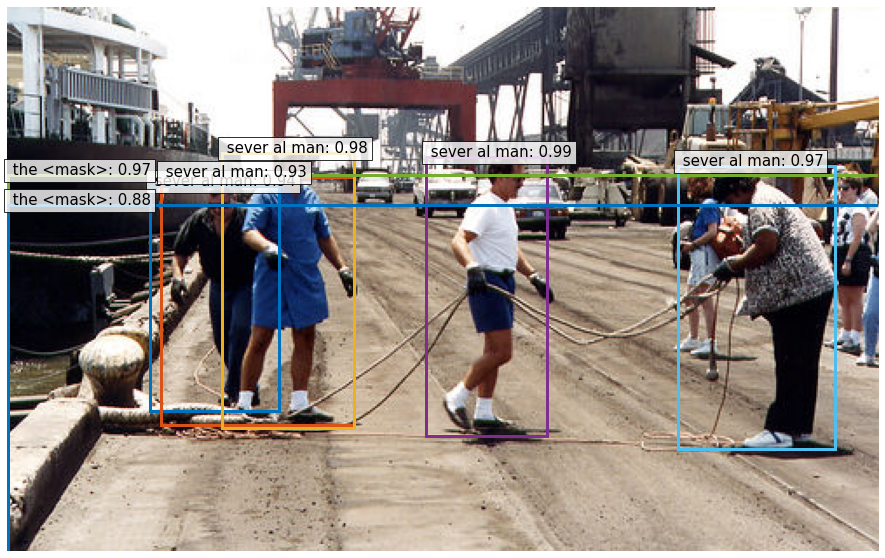

In [6]:
im = Image.open("/scratch/chaijy_root/chaijy2/jiayipan/ACL/RefCloze/pretrain_data/flickr30k-images/301246.jpg")
text = "several man on the <mask> ."
outputs, memory_cache, raw_probs  = plot_inference(im, text, lang_only= False)

In [48]:
raw_probs.argsort()[-5:]

tensor([1816, 6429,  891,  390,  693], device='cuda:0')

In [54]:
for i in raw_probs.argsort()[-5:]:
  print(model.transformer.tokenizer.decode(i))

 girl
 lady
 couple
 women
 woman


### gradio web demo integration

In [14]:
torch.hub.download_url_to_file('https://cdn.pixabay.com/photo/2014/03/04/15/10/elephants-279505_1280.jpg', 'elephant.jpg')

  0%|          | 0.00/344k [00:00<?, ?B/s]

In [15]:
import gradio as gr

In [ ]:
title = "MDETR"
description = "Gradio demo for our model."
examples =[['elephant.jpg','a baby <mask>']]
gr.Interface(
    plot_inference, 
    [gr.inputs.Image(type="pil", label="Input"), gr.inputs.Textbox(label="input text")], 
    [gr.outputs.Image(type="file", label="Output"), gr.outputs.Textbox(label="Predicted Words")],
    title=title,
    description=description,
    examples=examples,
    ).launch(debug=True, enable_queue=True)

/home/jiayipan/.conda/envs/na/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/home/jiayipan/.conda/envs/na/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/home/jiayipan/.conda/envs/na/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


IMPORTANT: You are using gradio version 3.0.24, however version 3.14.0 is available, please upgrade.
--------
Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/home/jiayipan/.conda/envs/na/lib/python3.9/site-packages/gradio/routes.py", line 255, in run_predict
    output = await app.blocks.process_api(
  File "/home/jiayipan/.conda/envs/na/lib/python3.9/site-packages/gradio/blocks.py", line 548, in process_api
    predictions, duration = await self.call_function(fn_index, processed_input)
  File "/home/jiayipan/.conda/envs/na/lib/python3.9/site-packages/gradio/blocks.py", line 463, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/home/jiayipan/.conda/envs/na/lib/python3.9/site-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/home/jiayipan/.conda/envs/na/lib/python3.9/site-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/home/jiayipan/.conda/envs/na/lib/python3.9/site-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.r